In [1]:
import os
import re
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constant to convert from Bohr (atomic units) to Ångström
BOHR_TO_ANGSTROM = 0.52917721092

# Periodic table mapping atomic numbers to element symbols
PERIODIC_TABLE = {
    1: 'H', 2: 'He', 3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
    11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar',
    19: 'K', 20: 'Ca', 26: 'Fe', 29: 'Cu', 47: 'Ag', 79: 'Au'
    # Extend as needed
}


def parse_fchk(filepath, convert_to_angstrom=True):
    """
    Parses a .fchk file to extract:
      - Number of atoms
      - Atomic numbers list
      - Cartesian coordinates (3*N floats)
    Returns a dict with keys: file, natoms, formula, element counts, coords (Nx3 ndarray).
    Coordinates are converted to Å if convert_to_angstrom is True.
    """
    data = {'file': os.path.basename(filepath), 'natoms': 0, 'atomic_numbers': [], 'coords': None}
    with open(filepath) as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line.startswith('Number of atoms') or line.startswith('NAtoms'):
            data['natoms'] = int(line.split()[-1])
        elif line.startswith('Atomic numbers'):
            count = int(line.split()[-1])
            vals, i = [], i+1
            while len(vals) < count and i < len(lines):
                vals.extend(map(int, lines[i].split()))
                i += 1
            data['atomic_numbers'] = vals[:count]
            continue
        elif line.startswith('Cartesian coordinates'):
            count = int(line.split()[-1]) * 3
            vals, i = [], i+1
            while len(vals) < count and i < len(lines):
                vals.extend(map(float, lines[i].split()))
                i += 1
            coords = np.array(vals[:count]).reshape(-1, 3)
            # convert units if needed
            if convert_to_angstrom:
                coords *= BOHR_TO_ANGSTROM
            data['coords'] = coords
            continue
        i += 1

    # Map atomic numbers to symbols and counts
    symbols = [PERIODIC_TABLE.get(z, f'El{z}') for z in data['atomic_numbers']]
    counts = Counter(symbols)
    formula = ''.join(f"{el}{cnt if cnt>1 else ''}" for el, cnt in sorted(counts.items()))
    data.update(counts)
    data['formula'] = formula

    return data


def compute_planarity(coords, return_raw_sigma=False, tol=1e-8):
    """
    Fits a plane via PCA and returns the RMS distance of points to that plane.
    If return_raw_sigma is True, also returns the smallest singular value sigma3.
    """
    cent = coords.mean(axis=0)
    pts = coords - cent
    u, s, vh = np.linalg.svd(pts, full_matrices=False)
    sigma3 = s[-1]
    rms = sigma3 / np.sqrt(len(coords))
    if sigma3 < tol:
        print(f"Smallest singular value {sigma3:.2e} < tol -> molecule essentially planar")
    if return_raw_sigma:
        return rms, sigma3
    return rms


def analyze_folder(folder_path, convert_to_angstrom=True):
    """
    Reads all .fchk files and returns a DataFrame summary with:
      - file, natoms, formula, element counts
      - planarity_rms and raw_sigma3
    """
    records = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith('.fchk'):
            rec = parse_fchk(os.path.join(folder_path, fname), convert_to_angstrom)
            if rec['coords'] is not None:
                rms, sigma3 = compute_planarity(rec['coords'], return_raw_sigma=True)
                rec['planarity_rms'] = rms
                rec['raw_sigma3'] = sigma3
            else:
                rec['planarity_rms'] = np.nan
                rec['raw_sigma3'] = np.nan
            records.append(rec)

    df = pd.DataFrame(records).fillna(0)
    df['natoms'] = df['natoms'].astype(int)
    return df

# Plotting functions (unchanged)


def plot_atom_count_histogram(df, bins=20, save_path=None):
    plt.figure()

    bins = np.arange(0, 22, 2)
    plt.hist(df['natoms'], bins=bins)
    plt.xlabel('Number of Atoms')
    plt.ylabel('Frequency')
    plt.title('Atom Count Distribution')
    plt.xticks(bins)
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()


def plot_element_frequency(df, save_path=None):
    elems = [col for col in df.columns if col not in ('file', 'natoms', 'formula', 'coords', 'planarity_rms')]
    numeric = df[elems].select_dtypes(include=[np.number])
    totals = numeric.sum().sort_values(ascending=False)
    plt.figure()
    plt.bar(totals.index, totals.values)
    plt.xlabel('Element')
    plt.ylabel('Total Count')
    plt.title('Element Frequency Across Molecules')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()


def plot_element_bar(df, element, save_path=None):
    plt.figure()
    plt.bar(df['file'], df[element])
    plt.xticks(rotation=90)
    plt.xlabel('File')
    plt.ylabel(f'Count of {element}')
    plt.title(f'{element} Count per Molecule')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()


def plot_planarity_bar(df, save_path=None):
    plt.figure()
    plt.bar(df['file'], df['planarity_rms'])
    plt.xticks(rotation=90)
    plt.xlabel('File')
    plt.ylabel('Planarity RMS (Å)')
    plt.title('Molecular Planarity by RMS Distance')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()


def plot_planarity_histogram(df, bins=20, save_path=None):
    plt.figure()
    plt.hist(df['planarity_rms'], bins=bins)
    plt.xlabel('Planarity RMS (Å)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Molecular Planarity')
    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.show()



/tmp/ipykernel_3137779/3386741961.py:106: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(records).fillna(0)


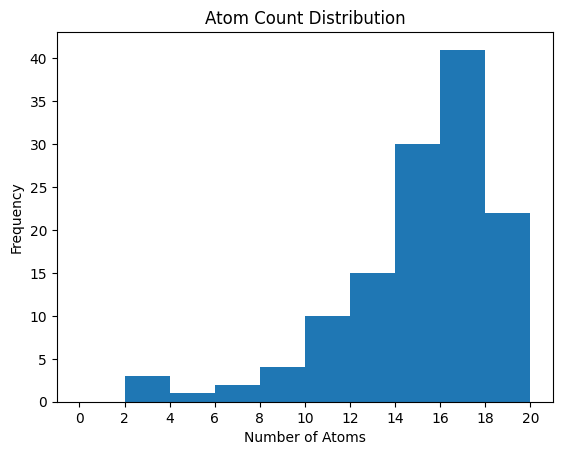

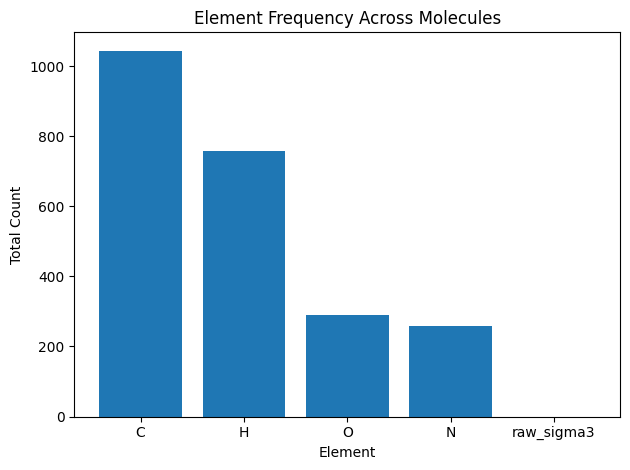

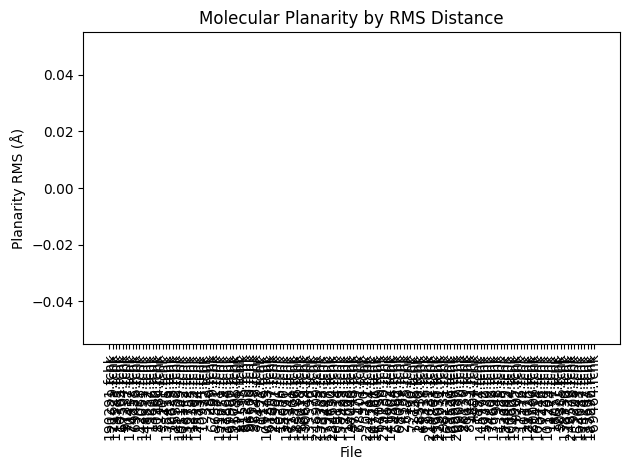

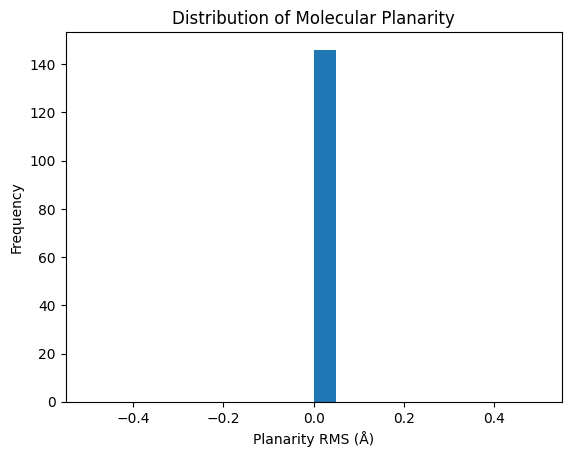

In [3]:
if __name__ == '__main__':
    #import argparse
    #parser = argparse.ArgumentParser(description='Analyze .fchk files and plot')
    #parser.add_argument('folder', help='Directory with .fchk files')
    #parser.add_argument('-o', '--output', default='summary.csv', help='CSV output')
    #parser.add_argument('--plot-prefix', default='plot_', help='Prefix for saved plots')
    #args = parser.parse_args()


    #folder = '/scratch/phys/sin/sethih1/data_files/first_group/'
    folder = "/scratch/phys/sin/sethih1/data_files/all_group_plane_fchk_split/part1"

    df = analyze_folder(folder)
    #df.to_csv(args.output, index=False)
    #print(f"Summary saved to {args.output}")

    # Generate and save visualizations
    plot_atom_count_histogram(df, save_path=f"atoms_hist.png")
    plot_element_frequency(df, save_path=f"elem_freq.png")


    plot_planarity_bar(df, save_path=f"planarity_bar.png")
    plot_planarity_histogram(df, save_path=f"planarity_hist.png")
    # Example per-element plot: C, H, O if present
    '''
    for el in ('C', 'H', 'O'):
        if el in df.columns:
            plot_element_bar(df, el, save_path=f"{el}_bar.png")
            '''

In [7]:
df['planarity_rms']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2241    0.0
2242    0.0
2243    0.0
2244    0.0
2245    0.0
Name: planarity_rms, Length: 2246, dtype: float64

In [8]:

filepath = '/scratch/phys/sin/sethih1/data_files/first_group/13157.fchk'
data = parse_fchk(filepath, convert_to_angstrom=True)


In [10]:
def compute_planarity(coords, return_raw_sigma=False, tol=1e-8):
    """
    Fits a plane via PCA and returns the RMS distance of points to that plane.
    If return_raw_sigma is True, also returns the smallest singular value sigma3.
    """
    cent = coords.mean(axis=0)
    pts = coords - cent
    u, s, vh = np.linalg.svd(pts, full_matrices=False)
    print("Singular values:", s)            # Should be in descending order
    normal = vh[-1]
    print("Plane normal (vh[-1]):", normal) # Should be unit‐length
    sigma3 = s[-1]
    rms = sigma3 / np.sqrt(len(coords))
    if sigma3 < tol:
        print(f"Smallest singular value {sigma3:.2e} < tol -> molecule essentially planar")
    if return_raw_sigma:
        return rms, sigma3
    return rms

In [12]:
rms, sigma3 = compute_planarity(data['coords'], return_raw_sigma=True)

AttributeError: 'NoneType' object has no attribute 'mean'

In [13]:
data

{'file': '13157.fchk',
 'natoms': 18,
 'atomic_numbers': [8, 8, 7, 7, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'coords': None,
 'O': 2,
 'N': 3,
 'C': 4,
 'H': 9,
 'formula': 'C4H9N3O2'}

In [14]:
df

,file,natoms,atomic_numbers,coords,N,C,H,formula,planarity_rms,raw_sigma3,O
0,142487.fchk,16,"[7, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,2.0,4.0,10.0,C4H10N2,0.0,0.0,0.0
1,190291.fchk,10,"[8, 8, 6, 6, 6, 6, 1, 1, 1, 1]",0,0.0,4.0,4.0,C4H4O2,0.0,0.0,2.0
2,179383.fchk,10,"[8, 8, 6, 6, 6, 6, 1, 1, 1, 1]",0,0.0,4.0,4.0,C4H4O2,0.0,0.0,2.0
3,79604.fchk,18,"[8, 8, 7, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",0,1.0,8.0,7.0,C8H7NO2,0.0,0.0,2.0
4,100522.fchk,19,"[8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, ...",0,4.0,3.0,4.0,C3H4N4O8,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...
2241,162033.fchk,15,"[8, 8, 8, 7, 7, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1]",0,2.0,4.0,6.0,C4H6N2O3,0.0,0.0,3.0
2242,151139.fchk,17,"[8, 8, 8, 8, 8, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, ...",0,0.0,6.0,6.0,C6H6O5,0.0,0.0,5.0
2243,7896.fchk,16,"[8, 8, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0,0.0,4.0,10.0,C4H10O2,0.0,0.0,2.0
2244,7951.fchk,19,"[7, 7, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, ...",0,2.0,7.0,10.0,C7H10N2,0.0,0.0,0.0
